**基本介绍**

Word2Vec的训练模型本质上是只具有一个隐含层的神经元网络。

Google开源的word2vec工具有两个突出的特点：

有两个特点：

1、word2vec可以在百万数量级的词典和上亿的数据集上进行高效地训练

2、该工具得到的训练结果，词向量，可以很好地度量词与词之间的相似性。

**0、如何表示一段文本？**

如何计算一段文本序列在某种语言下出现的概率？最基本方法就是
$$P(S)=\prod_{i=1}^TP(w_t|w_1,w_2,...,w_{t-1})$$

但参数量过大，实际应用是不可能的。

因此，得到其简化版--NGram。即令：
$$P(w_t|w_1,w_2,...,w_{t-1})=P(w_t|w_{t-n+1},...,w_{t-1})$$

但NGram仍然存在参数爆炸的问题（当N>3时）。并且，并没有考虑词与词之间的相似性。

所以，本质上仍然是一个one-hot的方法。

于是，就有了Distributed-Representation，分布式表示。使用一个连续的稠密向量表示。

2003年Bengio发表了NNLM(Neural Network Language Model)，
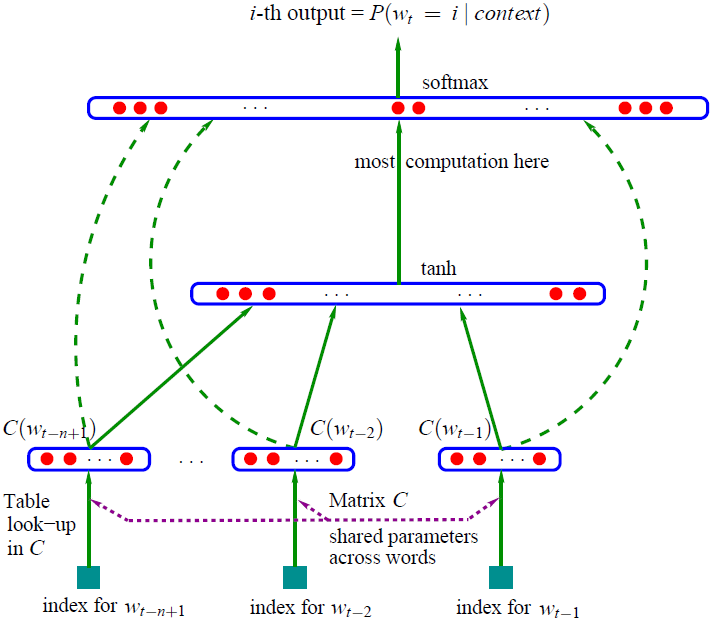

特点：

1、特征映射：利用了上下文，即前N个来预测当前，并且使用了共享的特征矩阵(V*M)来表示

2、计算条件概率：利用softmax从V个词中选取最可能的。如图可知softmax前的输入为

$$y=b+Wx+Utanh(d+Hx)$$

其中，$x=(C_{t-N+1},C_{t-N+2},...,C_{t-1})$，即向量表示的词。因而模型参数包括：$(b, W, U, d, H, C)$。图中虚线表示，词向量表示可以作为一部分输入，也可以忽略。若作为输入，则softmax输入的维度是$M*(n-1)+M*(n-1)$，若不作为输入，则是$M*(n-1)$。

换另一个角度来看，直连时候的FFNNLM模型，相当于是短接了。即

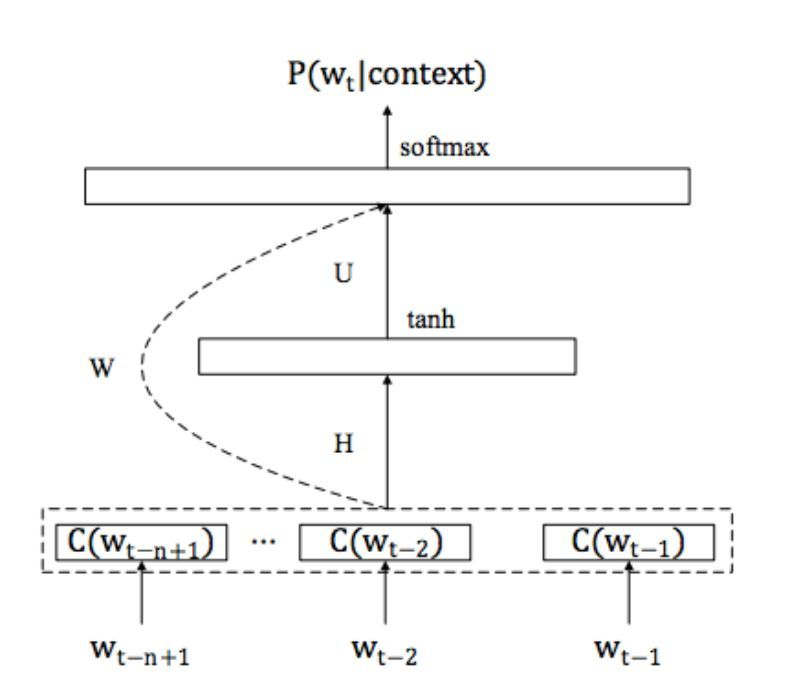


FFNNLM的训练可以拆分成两个步骤：

1、用一个简单模型训练出连续的词向量；

2、基于词向量的表达，训练一个连续的Ngram神经网络模型。

In [32]:
# NNLM的实现

import tensorflow as tf
import numpy as np

sentences = [ "i like dog", "i love coffee", "i hate milk"]
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = dict()
number_dict = dict()
for idx, word in enumerate(word_list):
    word_dict[word] = idx
    number_dict[idx] = word
n_class = len(word_dict)

n_step = len(sentences[0].split())-1
n_hidden = 2
m = 2

def make_batch(sentences):
    input_batch = []
    target_batch = []

    for sen in sentences:
        word = sen.split()
        input = [word_dict[n] for n in word[:-1]] 
        target = word_dict[word[-1]] 

        input_batch.append(input) 
        target_batch.append(target) 

    return input_batch, target_batch

"""预处理数据"""
input_data, target_data = make_batch(sentences)
x_train, y_train = np.array(input_data), np.array(target_data)

In [81]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024)    
train_dataset = train_dataset.batch(256)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
for x, y in train_dataset:
    print(x, y)

tf.Tensor(
[[5 3]
 [5 4]
 [5 6]], shape=(3, 2), dtype=int64) tf.Tensor([1 0 2], shape=(3,), dtype=int64)


In [73]:
from tensorflow.keras.layers import Dense, Embedding, Flatten

# 构建模型
class NNLM(tf.keras.Model):
    def __init__(self, simplified=True):
        super().__init__()
        self.simplified = simplified
        self.C = Embedding(n_class, m)
        self.H = tf.Variable(tf.random.normal([n_step * m, n_hidden]), name='H')
        self.W = tf.Variable(tf.random.normal([n_step * m, n_class]), name='W')
        self.U = tf.Variable(tf.random.normal([n_hidden, n_class]), name='U')
        self.d = tf.Variable(tf.random.normal([n_hidden]), name='d')
        self.b = tf.Variable(tf.random.normal([n_class]), name='b')
    
    def call(self, x):
        X = self.C(x)
        X = tf.reshape(X, [-1, n_step * m])
        hidden_out = tf.tanh(self.d + tf.matmul(X, self.H))
        y = self.b + tf.matmul(hidden_out, self.U)
        if not self.simplified:
            y += tf.matmul(X, self.W)
        
        return y

In [88]:
model = NNLM(simplified=False)
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
sparse_categorical_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
step = 0

for epoch in range(1000):
    for x, y in train_dataset:
        with tf.GradientTape() as tape:
            y_pred = model(x)
            loss = criterion(y_true=y, y_pred=y_pred)
            loss = tf.reduce_mean(loss)
            sparse_categorical_accuracy.update_state(y_true=y, y_pred=y_pred)
            train_acc = sparse_categorical_accuracy.result()
            
        gradients = tape.gradient(loss, model.variables)
        optimizer.apply_gradients(grads_and_vars=zip(gradients, model.variables))
        if step % 10 == 0:
            print(train_acc)
        step += 1
m_model.summary()

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.013266998, shape=(), dtype=float32)
tf.Tensor(0.034755133, shape=(), dtype=float32)
tf.Tensor(0.078431375, shape=(), dtype=float32)
tf.Tensor(0.11832612, shape=(), dtype=float32)
tf.Tensor

In [93]:
tf.argmax(model(np.array([5,4])), 1)

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>

**1、Bengio的FFNNLM的优缺点？**


优点：

FFNNLM 通过将单词转换为低维向量克服了维数诅咒。FFNNLM 引领了 NNLM 研究的潮流。

缺点：

1、在训练前指定的上下文大小是有限的，这与人类可以使用大量的上下文信息进行预测的事实是严重不符的。

2、序列中的单词是时序相关的。而FFNNLM 没有使用时序信息进行建模。

3、全连接NN需要学习许多可训练的参数，即使这些参数的数量比NGram少，但是仍然具有很大的计算开销，输出层在billion级别的词汇中，计算softmax的开销巨大，训练太慢了，十分低效。

**1、word2vec是什么？**

NNLM是得到一句话的表征，而FFNNLM训练时，先是对词进行表征，然后用NGram的方法，即前N个词来训练。

所以，如果只是单纯为了得到词的表征，第二步是可以进行简化的。也就是说，word2vec主要任务目标就是为了训练得到词向量，而不再是NNLM的任务。

Google的Mikolov逐步做了以下一些优化点，包括：

1、移除NNLM中前向反馈神经网络中非线性的hidden layer，直接将中间层的Embedding layer与输出层的softmax layer连接

2、忽略上下文环境的序列信息：输入的所有词向量均汇总到同一个Embedding layer

3、将Future words纳入上下文环境CBoW依然是用上下文来预测中心词，适合于数据集较小的情况；而Skip-gram是根据中心词来预测其上下文单词，在大型语料中表现更好。

而在word2vec的论文中，Mikolob提到：

The main observation from the previous section（比如FFNNLM、RNNNNLM等） was that most of the complexity is caused by the non-linear hidden layer in the model. While this is what makes neural networks so attractive, we decided to explore simpler models that might not be able to represent the data as precisely as neural networks, but can possibly be trained on much more data efficiently.


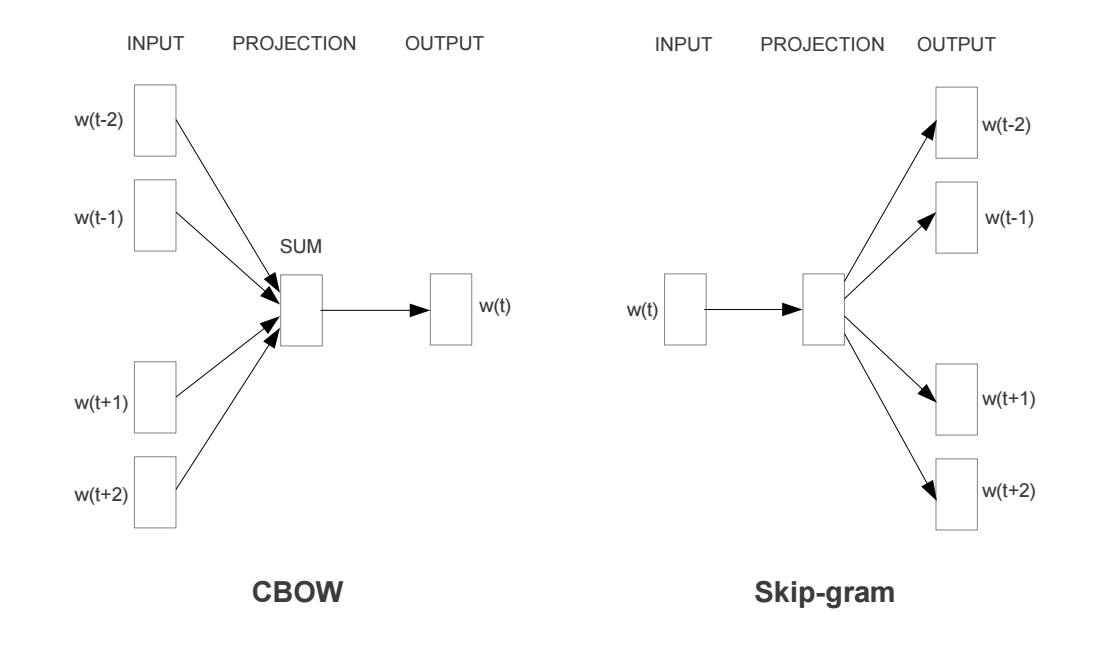


CBoW介绍：

CBOW没有隐藏层，本质上只有两层结构，输入层将目标词语境context中的每一个词向量**简单求和（当然，也可以求平均）** 后得到语境向量$x$，然后直接与目标词的输出向量$e'(\omega_t)$求点积，目标函数也就是要让这个与目标词向量的点积取得最大值，对应的与非目标词的点积尽量取得最小值。其目标函数是：
$$\frac{1}{T}\sum_{t=1}^TP(w_t|c_t)\\
其中，P(w_t|c_t)=\frac{exp(e'(\omega_t)^T)x}{\sum_{i=1}^Vexp(e'(\omega_i)^Tx)},且x = \sum_{i \in c}e(w_i)
$$


Skip-Gram介绍：

Skip-gram的模型基本思想和CBOW非常类似，只是换了一个方向。CBOW是让目标词的输出向量拟合语境的向量；而Skip-gram则是让语境中每个词的输出向量尽量$e'(\omega_i)$拟合当前输入词的向量$e(\omega_t)$，和CBOW的方向相反。其目标函数为：
$$\frac{1}{T}\sum_{t=1}^T\sum_{j \in C}P(w_j|c_t)\\
其中，P(w_j|c_t)=\frac{exp(e'(\omega_j)^Te(\omega_t))}{\sum_{i=1}^Vexp(e'(\omega_i)^Te(\omega_t))}
$$



无论CBOW还是Skip-gram，本质上都是两个全连接层的相连，中间没有任何其他的层。


但依然需要解决softmax的问题，这里，Mikolov提出了以下几个trick：

1、结构优化：Hierachical Softmax代替softmax
    
    第一，将词典中的每个词按照词频大小构建出一棵Huffman树，保证词频较大的词处于相对比较浅的层，词频较低的词相应的处于Huffman树较深层的叶子节点，每一个词都处于这棵Huffman树上的某个叶子节点。
    
    第二，将原本的一个|V|分类问题变成了log|V|次的二分类问题，在计算P(w_t|context)时，变成了在Huffman树中的路径预测问题。而树深不过log|V|。
    
2、样本优化：负采样

普通softmax的计算量太大就是因为它把词典中所有其他非目标词都当做负例了。而负采样的思想特别简单，就是每次按照一定概率随机采样一些词当做负例，从而就只需要计算这些负采样出来的负例了。以CBoW为例，概率公式的变化为：

$$P(w_t|c_t)=\frac{exp(e'(w_t)^Tx)}{\sum_{i=1}^Vexp(e'(w_i)^Tx)}  \rightarrow P(w_t|c_t)=\frac{exp(e'(w_t)^Tx)}{\sum_{i=1}^Kexp(e'(w_i)^Tx)}$$

**也就是将原来的V分类问题变成了K分类问题。**


3、其他技巧：下采样

超频频率词作为停用词，或者下采样，比如构造丢弃概率函数：$$P_{discard}(\omega)=1-\frac{t}{f(\omega)}$$
其中，t是超参数可取$10^{-5}$，$f(\omega)$是词频


参考：https://coladrill.github.io/2018/12/10/自然语言处理的发展/

In [132]:
# Tensorflow中skip-gram的训练过程，参考https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/word2vec.ipynb

import io
import re
import string
import tqdm

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [189]:
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
    '''
    生成训练样本
    param sequences: 文本
    param window_size: gram框
    param num_ns: 负采样率，小数据集为【5-20】，大数据集为【2-5】
    param vocab_size: 词典大小
    param seed: 随机数
    '''
    targets, contexts, labels = [], [], []

    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)
    
    for sequence in tqdm.tqdm(sequences):
        # 求每段文本的skip-gram pairs
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
              sequence,
              vocabulary_size=vocab_size,
              sampling_table=sampling_table,
              window_size=window_size,
              negative_samples=0)
        
        # 对每个pair求target_word对应的negative words（不包含context_word）
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
              true_classes=context_class,
              num_true=1,
              num_sampled=num_ns,
              unique=True,
              range_max=vocab_size,
              seed=seed,
              name="negative_sampling")
            
            context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")

            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return targets, contexts, labels

In [192]:
# 文本向量化，使用4096的词典，
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

text_ds = tf.data.TextLineDataset(path_to_file).filter(lambda x: tf.cast(tf.strings.length(x), bool))

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation), '')
vocab_size = 4096
sequence_length = 10

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

vectorize_layer.adapt(text_ds.batch(1024))

text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

sequences = list(text_vector_ds.as_numpy_iterator())
for seq in sequences[:5]:
    print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

[ 89 270   0   0   0   0   0   0   0   0] => ['first', 'citizen', '', '', '', '', '', '', '', '']
[138  36 982 144 673 125  16 106   0   0] => ['before', 'we', 'proceed', 'any', 'further', 'hear', 'me', 'speak', '', '']
[34  0  0  0  0  0  0  0  0  0] => ['all', '', '', '', '', '', '', '', '', '']
[106 106   0   0   0   0   0   0   0   0] => ['speak', 'speak', '', '', '', '', '', '', '', '']
[ 89 270   0   0   0   0   0   0   0   0] => ['first', 'citizen', '', '', '', '', '', '', '', '']


In [193]:
# 生成训练数据
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=2,
    num_ns=4,
    vocab_size=vocab_size,
    seed=SEED)

BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

100%|██████████| 32777/32777 [00:07<00:00, 4174.80it/s]


<PrefetchDataset shapes: (((1024,), (1024, 5)), (1024, 5)), types: ((tf.int32, tf.int64), tf.int64)>


In [194]:
# 构建模型

class Word2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, num_ns):
        super().__init__()
        self.target_embedding = layers.Embedding(vocab_size, embedding_dim, input_length=1, name="w2v_embedding")
        self.context_embedding = layers.Embedding(vocab_size, embedding_dim, input_length=num_ns+1)
    
    def call(self, pair):
        target, context = pair
        if len(target.shape) == 2:
            target = tf.squeeze(target, axis=1)
        word_emb = self.target_embedding(target)
        context_emb = self.context_embedding(context)
        dots = tf.einsum('be,bce->bc', word_emb, context_emb)
        
        return dots

In [196]:
embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim, num_ns)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
word2vec.fit(dataset, epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20
63/63 [==============================] - 1s 7ms/step - loss: 1.6083 - accuracy: 0.2313
Epoch 2/20
63/63 [==============================] - 0s 4ms/step - loss: 1.5893 - accuracy: 0.5538
Epoch 3/20
63/63 [==============================] - 0s 4ms/step - loss: 1.5430 - accuracy: 0.6003
Epoch 4/20
63/63 [==============================] - 0s 5ms/step - loss: 1.4623 - accuracy: 0.5731
Epoch 5/20
63/63 [==============================] - 0s 4ms/step - loss: 1.3652 - accuracy: 0.5827
Epoch 6/20
63/63 [==============================] - 0s 4ms/step - loss: 1.2674 - accuracy: 0.6117
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 1.1752 - accuracy: 0.6449
Epoch 8/20
63/63 [==============================] - 0s 5ms/step - loss: 1.0897 - accuracy: 0.6789
Epoch 9/20
63/63 [==============================] - 0s 5ms/step - loss: 1.0106 - accuracy: 0.7107
Epoch 10/20
63/63 [==============================] - 0s 5ms/step - loss: 0.9374 - accuracy: 0.7408
Epoch 11/20
63/63 [

In [198]:
%load_ext tensorboard
%tensorboard --logdir logs

In [200]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()
weights[vocab.index('tomorrow')]

array([-0.17521194,  0.12385055,  0.12089615,  0.2734128 , -0.28998667,
       -0.01805324,  0.26247048, -0.20465791,  0.1576528 , -0.00413806,
       -0.25750616,  0.22485822, -0.07844011, -0.2798158 ,  0.08019186,
        0.00299484, -0.11780234, -0.41684335, -0.02040745,  0.30281383,
        0.05566092, -0.25376806,  0.03340237,  0.20008719,  0.09515813,
       -0.2720437 , -0.06276387, -0.15826893, -0.02661254, -0.45611444,
        0.24493998, -0.02786938,  0.20171213, -0.26116684,  0.31919044,
        0.0527057 , -0.3992201 , -0.12464438,  0.12833731, -0.04183063,
        0.1709372 ,  0.25740683,  0.17780663, -0.28458643, -0.135969  ,
       -0.50104326,  0.11329921,  0.00398449,  0.01877193, -0.12478317,
       -0.2269789 ,  0.07703248, -0.05915397,  0.18599169,  0.11357239,
        0.37050843, -0.0830081 ,  0.06937751, -0.17808615, -0.00923726,
        0.19877936,  0.01308159,  0.00380655,  0.15349199, -0.37447792,
        0.24346828, -0.19920433, -0.14554842,  0.05142447,  0.27